# GSP Final Project
In this notebook, we will demonstrate estimation of graph signals using a GSP-based technique vs.  a deep-learning-based technique. 

In [1]:
import util
import torch
import torch.nn as nn
import numpy as np
import scipy.sparse as ssparse
import scipy.io as sio
import torch_geometric as tg
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [2]:
# Enable CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 22 17:41:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   38C    P8              3W /   55W |     715MiB /   8188MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Task

$$\mathbf{x} \longrightarrow  \boxed{\text{Physical Model}} \longrightarrow \mathbf{y}  \longrightarrow \boxed{\text{Estimator}}  \longrightarrow \hat{\mathbf{x}}$$ 

### Physical Model
$$ \mathbf{y} = \mathbf{g}(\mathbf{x};\mathbf{L}) + \mathbf{w} $$

- $\mathbf{x} \sim p(\mathbf{x})$.
- $\mathbf{g}$ - a non-linear measurement function.
- $\mathbf{L}$ - the Laplacian matrix of the graph.
 
### Estimator
- $\mathbf{y}$ - input of the estimator
- $\mathbf{x}$ - ground-truth corresponding label
- The estimator is given a dataset pairs of $\{\mathbf{x_t}, \mathbf{y_t} \}_t$ for training.

**Goal**: The estimator should recover $\mathbf{x}$ out of $\mathbf{y}$ with minimum MSE.
#### GSP-based

Use a GSP-based technique for estimation.

#### GNN-based

Use a GNN deep-learning architecture for estimation.

**NOTE:**  $\mathbf{y}$ is the input to the DP model and $\mathbf{x}$ is the output (i.e., the label) not vise versa!

## Part 1: Physical Model

In [2]:
def laplacian_evd(Y):
    L = - np.imag(Y)
    Lambda, V = np.linalg.eig(L)
    Lambda = np.real(Lambda)
    sorted_indices = np.argsort(Lambda)
    Lambda = Lambda[sorted_indices]
    Lambda = np.diag(Lambda)
    V = V[:, sorted_indices]
    return L, Lambda, V
    
def g_xL(Y, x):
    v = np.exp(1j * x)
    g_x = np.real(v * np.conj(Y @ v))
    return g_x
    
def generate_data(nt, Y, Lambda, V, beta=3, c_ww=0.05):
    N = Y.shape[0]
    xt = (V[:, 1:] @ np.random.multivariate_normal(np.zeros(N - 1), beta * np.diag(1 / np.diag(Lambda)[1:]), nt).T).T
    if nt == 1:
        xt = xt[0, :]
    
    yt = np.zeros(xt.shape)
    for t in range(0, nt):
        yt[t] = g_xL(Y, xt[t])
    yt += np.sqrt(c_ww) * np.random.randn(yt.shape[0], yt.shape[1])
    
    return xt, yt

filename = 'grid_data_ieee118cdf.mat'
grid_data = sio.loadmat(filename)
Y = grid_data['Y']
N = Y.shape[0]
nt = 1000

L, Lambda, V = laplacian_evd(Y)
xt_train, yt_train = generate_data(nt, Y, Lambda, V, )

## Part 2: GSP-LMMSE Estimator

The GSP-LMMSE estimator is defined as an estimator which minimize the MSE among all estimators in the form of a graph filter:
$$
\{\bf{h}, \bf{b} \} = \text{argmin}~ \mathbb{E} [(\bf{x} - \hat{\bf{x}}(\bf{y}))^2]
$$

where $\hat{\bf{x}}(\bf{y}) =  \bf{V} \text{diag} (\bf{h}) \bf{V}^T \bf{y}+ \bf{b}$.

A closed form expression would be:
$$ \hat{\bf{x}}(\bf{y}) =  \bf{V} \text{diag} (\bf{d}_{\bf{xy}}\oslash \bf{d}_{\bf{yy}}) \bf{V}^T \bf{y} + \bar{\bf{x}}$$

where $\bf{d}_{\bf{xy}} := \text{diag}(\text{cov}(\bf{V}^T \bf{x}, \bf{V}^T \bf{y}))$, $\bf{d}_{\bf{yy}} := \text{diag}(\text{var}(\bf{V}^T \bf{y}))$ and $\bar{\bf{x}} :=\mathbb{E}\bf{x}$

In [3]:
def train_gsp_lmmse_estimator(xt, yt, V):
    xt = xt.T     # column vectors representation
    yt = yt.T     # column vectors representation

    xt_mean = np.mean(xt, axis=1)[:, np.newaxis]
    yt_mean = np.mean(yt, axis=1)[:, np.newaxis]

    d_xy = np.mean( ( V.T @ (xt - xt_mean) ) * ( V.T @ (yt - yt_mean) ) , axis=1)

    d_yy = np.mean( ( V.T @ (yt - yt_mean) ) ** 2 , axis=1)
    
    h = d_xy / d_yy
    
    return h, xt_mean

## Part 3: GNN and Deep Learning based Estimation

### Define Model Architecture

In [35]:
class GNN(torch.nn.Module):
    def __init__(self, K = 30 ):  # K is the order of the Chebyshev polynomial
        super(GNN, self).__init__()
        
        self.conv1 = tg.nn.ChebConv(1, 1, K=K, normalization=None)
        self.relu1 = nn.ReLU()
        self.conv2 = tg.nn.ChebConv(1, 1, K=K, normalization=None)
        self.relu2 = nn.ReLU()
        self.conv3 = tg.nn.ChebConv(1, 1, K=K, normalization=None)  

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        print(x.dtype)
        print(data.edge_attr.dtype)
        x = self.conv1(x, edge_index=edge_index, edge_weight=data.edge_attr)
        x = self.relu1(x)
        x = self.conv2(x, edge_index=edge_index)
        x = self.relu2(x)
        x = self.conv3(x, edge_index=edge_index)
        return x


### Define training function

In order to run on GPU via CUDA set device accordingly.

In [25]:
def train_model(model, train_data, valid_data, edge_weight, batch_size=20, valid_batch_size = 50, epochs=40, lr=0.001, weight_decay=1e-4, path=None, device='cpu'):
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size=valid_batch_size, shuffle=False)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    train_mse, valid_mse = [], []
    
    for epoch in range(epochs):
                
        # Training
        model.train() 
        train_loss = 0
        iters = 0
        for data in train_loader:
            data = data.to(device) 
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += float(loss.item())
            iters += 1
        train_mse.append(train_loss / iters)

        # Validation
        model.eval()
        valid_loss = 0
        iters = 0
        with torch.no_grad():
            for data in valid_loader:
                data = data.to(device) 

                output = model(data)
                loss = criterion(output,data.y)
                valid_loss += float(loss.item())
                iters += 1
            valid_mse.append(valid_loss / iters)

        if valid_mse[-1] == max(valid_mse) and path is not None:
            print("Current State Saved")
            torch.save(model.state_dict(), path)

        print(f"Epoch: {epoch}, Train MSE {train_mse[-1]}, Validation MSE {valid_mse[-1]}")
    
    return train_mse, valid_mse
        
        
def plot_learning_curve(train_mse, valid_mse):
    plt.figure(figsize=(10, 5))
    plt.plot(train_mse, label='Training MSE', color='blue')
    plt.plot(valid_mse, label='Validation MSE', color='black')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

## Part 4: Train
### Train GSP-LMMSE Estimator

In [10]:
filename = 'grid_data_ieee118cdf.mat'
grid_data = sio.loadmat(filename)
Y = grid_data['Y']
N = Y.shape[0]
nt = 1000

L, Lambda, V = laplacian_evd(Y)
xt_total, yt_total = generate_data(nt, Y, Lambda, V )


In [29]:
h_gsp, b_gsp = train_gsp_lmmse_estimator(xt_train, yt_train, V)

TypeError: mean() received an invalid combination of arguments - got (axis=int, dtype=NoneType, out=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.

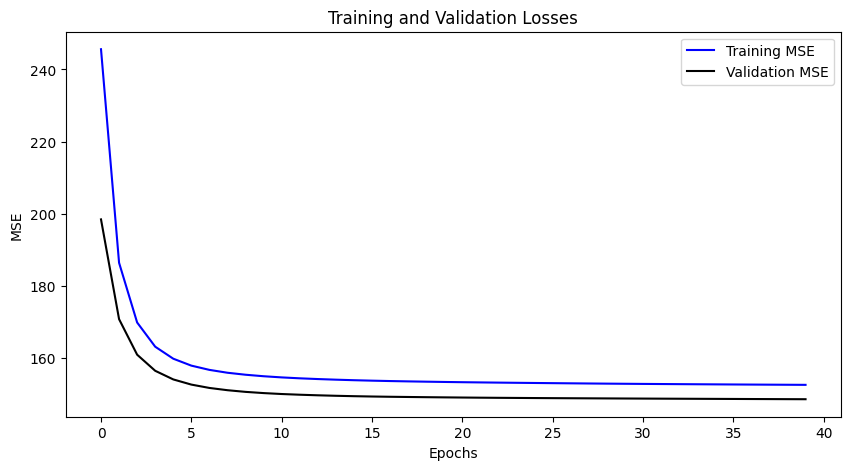

In [37]:
path = "./best_GNN_model.pk"
GNN_model = GNN()

L_sparse = ssparse.csr_matrix(np.diag(np.diag(L)) -L)
edge_index, edge_weight = tg.utils.from_scipy_sparse_matrix(L_sparse)

edge_weight = edge_weight.to(dtype=torch.float32)

device = 'cpu'
# NOTE: yt is the input for the model, and xt is the label, in Data object x is the input and y is the label!
yt_train = torch.tensor(xt_total, dtype=torch.float32)
xt_train = torch.tensor(yt_total, dtype=torch.float32)

total_data = [Data(x=yt_train[i].unsqueeze(-1), y=xt_train[i].unsqueeze(-1), edge_index=edge_index, edge_attr=edge_weight) for i in range(len(yt_train))]


train_data = total_data[:int(len(total_data) * 0.8)]
valid_data = total_data[int(len(total_data) * 0.8):]

GNN_model.to(device)


train_mse, valid_mse = train_model(GNN_model, train_data, valid_data, edge_weight, path=path)
plot_learning_curve(train_mse, valid_mse)

## Part 4: Comparison